In [20]:
import numpy as np
import dill
import pandas as pd
from scipy import optimize as opt
from sklearn.preprocessing import MinMaxScaler
import time
import sys
sys.path.append('../../')
import src


#Load policy and value function
#####################
file_n = "2018-10-5vfi_dict.dill" #Personal Macbook
#file_n = "2019-2-16vfi_dict.dill" #Work Macbook
with open('../../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


# Simulation parameters \
########################
σerror= 0.005 #0.01
Nfirms = 300
time_periods = 40
min_periods= 3

#Suitable for logistic
β10, β11 = -2, 3.5
β20, β21 = 1.3, -2.
betas = [β10, β11, β20, β21]

#GMM parameters
maxiters = 10 #120

#Basic elements for simulation
#xs = np.abs(np.random.normal(0, 0.18, size=Nfirms))
xs = np.random.normal(0.231, 1.213123, size=Nfirms)
scaler = MinMaxScaler()
xs = scaler.fit_transform(xs.reshape(-1, 1)).flatten()

prior_shocks = src.gen_prior_shocks(Nfirms, σerror=σerror)
dmd_shocks = src.generate_dmd_shocks(n=Nfirms, t=time_periods, dmd_σϵ=src.const.σ_ɛ)

#dataframe and standard deviation
df = src.simulate_all_firms(Nfirms, valueF, policyF, xs, θ=betas,
                            dmd_shocks=dmd_shocks, prior_shocks=prior_shocks)
std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=3)
            .std().reset_index()
            .rename(columns={'level_1': 't',
                            'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')

mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]

In [33]:
def f(x):
    return x

ipy.interact(f, x=10);



10

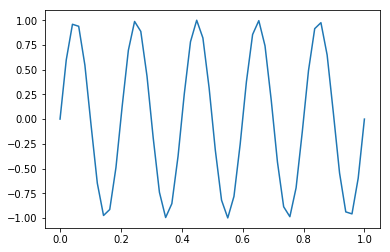

<function __main__.pltsin(f)>

In [32]:
import ipywidgets as ipy
t = np.linspace(0., 1., 50)
x = np.linspace(0, 1, 50)
def pltsin(f):
    plt.plot(x, np.sin(2*np.pi*t*f))
    plt.show()
    
ipy.interact(pltsin, f=(1, 10, 0.1))

In [ ]:
β10, β11 = -2.5, 2.5
β20, β21 = 1.3, -1.2
betas = [β10, β11, β20, β21]

[(betas[0] - 0.5, 0.5), (2.0, 4.0), (0.5, 2), (-3., 1.)]



Text(0.5,0.98,'Finding reasonable combinations of thetas and xs')

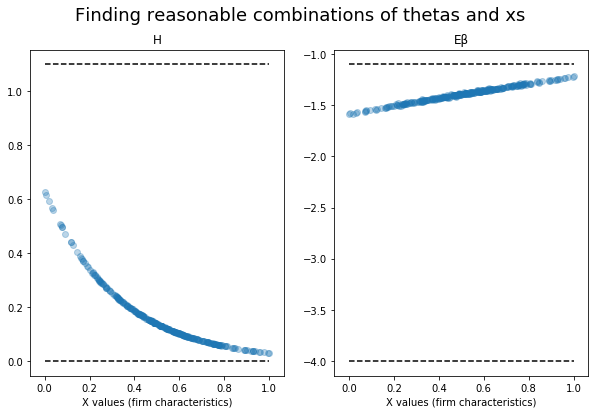

In [88]:
import matplotlib
#matplotlib.style.use('fivethirtyeight')
#Scatter plot of H, EB as function of x and prior_shocks

%matplotlib inline
import matplotlib.pyplot as plt

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
 
θ = np.array([-0.47, -3.03,  0.46, -0.26])

ax1.set_xlabel("X values (firm characteristics)")
ax2.set_xlabel("X values (firm characteristics)")
H = np.e**((θ[0] + θ[1]*xs + prior_shocks))
Eβ = -np.e**(θ[2] + θ[3]*xs + prior_shocks)
ax1.scatter(xs, H, alpha=0.3)
ax1.set_title("H")
max_H_value = np.log(3)
ax1.hlines(0., xs.min(), xs.max(), linestyles="dashed")
ax1.hlines(max_H_value, xs.min(), xs.max(), linestyles="dashed")
ax2.scatter(xs, Eβ, alpha=0.3)
ax2.hlines(src.betas_transition.min(), xs.min(), xs.max(), linestyles="dashed")
ax2.hlines(src.betas_transition.max(), xs.min(), xs.max(), linestyles="dashed")
ax2.set_title("Eβ")
fig.suptitle("Finding reasonable combinations of thetas and xs", size=18)

## Optimization

In [4]:
def error_w_data(θ) -> float:
    return src.gmm_error(θ, policyF, xs,
                      mean_std_observed_prices=mean_std_observed_prices, df=df,
                                 prior_shocks=prior_shocks, min_periods=min_periods)

start = time.time()

optimi = opt.differential_evolution(error_w_data, [(-2.5, 0.5), (2.5, 4.0),
                                                   (0.5, 2), (-3., 1.)],
                                    maxiter=maxiters)

time_taken = time.time()/60 - start/60
print("Taken {0} minutes for {1} iterations. {2} per iteration".format(
      time_taken, maxiters, time_taken/maxiters))
print("Success: ", optimi.success)
print("Valores reales: ", betas)
print("Optimizados: ", np.round(optimi.x, 2))
print("Errores porcentuales (de 1 a 100%): ", 
      np.round(200*(np.array(betas) - optimi.x)/(np.array(betas) + optimi.x), 2))


ind=88
realH = np.e**((betas[0] + betas[1]*xs[ind]))
realEβ = -np.e**(betas[2] + betas[3]*xs[ind])

estH = np.e**((optimi.x[0] + optimi.x[1]*xs[ind]))
estEβ = -np.e**(optimi.x[2] + optimi.x[3]*xs[ind])

print("H real y H estimado: ", realH, estH)
print("EB real y EB estimado: ", estH, estEβ)

print(betas)
src.betas_transition

../../src/from_parameters_to_lambdas.py:58: RuntimeWarning: overflow encountered in double_scalars
  deb_0 = ((βs[0] - βs[2]) * np.e ** (-x[0])) / (1 + np.e ** (-x[0])) ** 2
../../src/from_parameters_to_lambdas.py:50: RuntimeWarning: divide by zero encountered in log
  num0 = (-np.log(np.e ** x[0] / (np.e ** x[0] + 1)) + block) * np.e ** x[0]
../../src/from_parameters_to_lambdas.py:50: RuntimeWarning: invalid value encountered in double_scalars
  num0 = (-np.log(np.e ** x[0] / (np.e ** x[0] + 1)) + block) * np.e ** x[0]
../../src/from_parameters_to_lambdas.py:58: RuntimeWarning: invalid value encountered in double_scalars
  deb_0 = ((βs[0] - βs[2]) * np.e ** (-x[0])) / (1 + np.e ** (-x[0])) ** 2
../../src/from_parameters_to_lambdas.py:28: RuntimeWarning: overflow encountered in power
  return np.e**x / (1 + np.e**x)
../../src/from_parameters_to_lambdas.py:28: RuntimeWarning: invalid value encountered in true_divide
  return np.e**x / (1 + np.e**x)


Taken 21.62426120042801 minutes for 10 iterations. 2.162426120042801 per iteration
